In [1]:
%matplotlib inline

In [2]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat
from utils.ACfunctions import Cv, Cr

import h5py 
from scipy import integrate
import scipy.optimize

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [5]:
np.sqrt(5)*0.038

0.084970583144992

In [ ]:
import logging

logging.config.fileConfig("/home/ashmat/telegramLogConfig")

logger = logging.getLogger("telegram")

logger.info("gamma_estimate analyse autocorr grid done!")

In [2]:
with client.Session() as session:
    items = (session.query(Simulation)
                 .where(Simulation.hash=="08d15054b14ed56a")).all()[:]


In [3]:
with client.Session() as session:
    items = (session.query(Simulation)
                 .where(Simulation.group_name.in_(["GE 2.2"] ))
                 .order_by(Simulation.start_time)).all()[:]
errors = []
for item in tqdm(items):
    hdf_file = "/data/biophys/ashmat/LJ-magnetic/subresults/grid.{}.hdf5".format(item.hash)
    try:
        with h5py.File(hdf_file) as ds:
            for key in ds.keys():
                item.history[key] = np.mean(ds[key][:, :1000], axis=0, keepdims=True)
            
#             print(item.history[key].shape)
            item.history["Omega"] = ds.attrs["O"]

            item.history["Temp"] = ds.attrs["T"]
    except Exception as e:
        errors.append((item, hdf_file, e))
#     break

 55%|█████▌    | 14512/26320 [12:27:37<9:32:21,  2.91s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 75%|███████▍  | 19636/26320 [16:38:42<5:16:13,  2.84s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 26320/26320 [22:04:25<00:00,  3.02s/it]  


In [3]:
items = [item for item in items if item.history is not None]

/home/ashmat/miniconda3-vesta/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


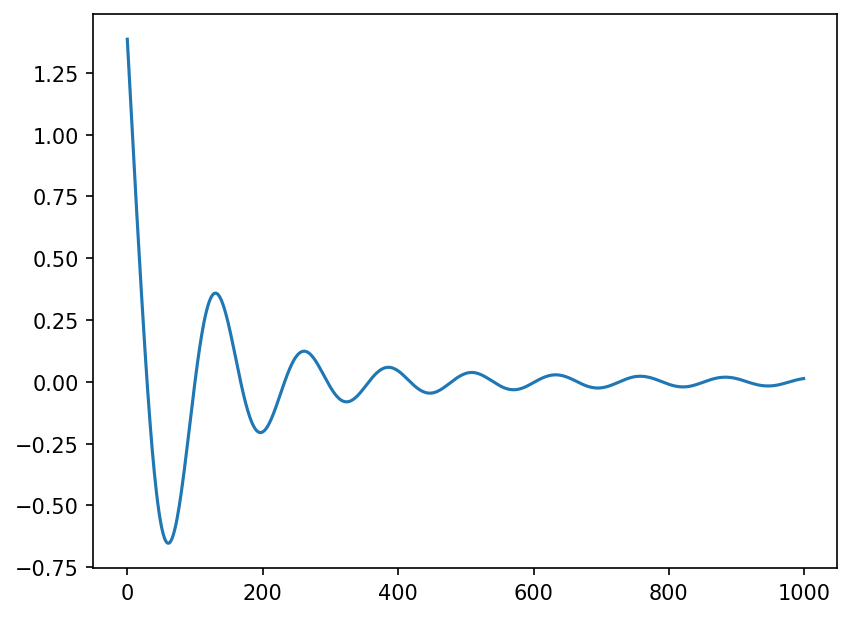

In [4]:
plt.plot(item.history["ac_vc"].mean(axis=0)[:2000])

In [5]:
dt = item.record_interval

In [6]:
len(set([round(item.L_init,3) for item in items]))
len(set([round(item.E_init,3) for item in items]))

25786

In [8]:
item.history.keys()

dict_keys(['hdf5', 'ac_vc', 'ac_vc_relative', 'ac_wc', 'ac_wc_relative', 'Omega', 'Temp'])

In [9]:
 
df = pd.DataFrame(
{
    "L_init":[round(item.L_init,3) for item in items],
    "E_init":[round(item.E_init,3) for item in items],
    "Omega": [round(item.history["Omega"],5) for item in items],
    "Temp":  [round(item.history["Temp"], 5) for item in items],
    "integral": [dt*integrate.simpson(item.history["ac_vc"]) for item in items],
    "integral_relative": [dt*integrate.simpson(item.history["ac_vc_relative"]) for item in items],
}
)

df["integral_relative_imag"] = np.imag(df["integral_relative"])

gb = df.groupby(["E_init", "L_init"])

gp = gb.get_group(list(gb.groups.keys())[0])

dfg = gb.apply(lambda gp:gp.mean())
dfg = dfg[dfg.Omega<0.6]

dfg["std"] = gb.apply(lambda gp:np.imag(gp.integral_relative).std())

dfg["g3"] = 2 * np.real(dfg.integral_relative) * (1-dfg.Omega**2)**2 / (0.0001 + 4 * dfg.Temp * dfg.Omega**2)

In [10]:
dfg.head()

,,L_init,E_init,Omega,Temp,integral,integral_relative,integral_relative_imag,std,g3
E_init,L_init,,,,,,,,,
201.893,12.964,12.964+0.000j,201.893+0.000j,0.08083+0.00000j,0.17295+0.00000j,-0.000190+0.037876j,0.015779+0.076112j,0.0+0.0j,0.0,6.742083+0.000000j
202.022,13.625,13.625+0.000j,202.022+0.000j,0.08490+0.00000j,0.17297+0.00000j,-0.000130+0.039843j,0.017391+0.079992j,0.0+0.0j,0.0,6.739190+0.000000j
202.156,14.288,14.288+0.000j,202.156+0.000j,0.08896+0.00000j,0.17301+0.00000j,-0.000270+0.041667j,0.019331+0.083857j,0.0+0.0j,0.0,6.823365+0.000000j
202.297,14.953,14.953+0.000j,202.297+0.000j,0.09305+0.00000j,0.17305+0.00000j,-0.000052+0.043652j,0.021145+0.088141j,0.0+0.0j,0.0,6.820708+0.000000j
202.445,15.620,15.620+0.000j,202.445+0.000j,0.09712+0.00000j,0.17309+0.00000j,-0.000066+0.045594j,0.022909+0.092037j,0.0+0.0j,0.0,6.780497+0.000000j


/home/ashmat/miniconda3-vesta/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


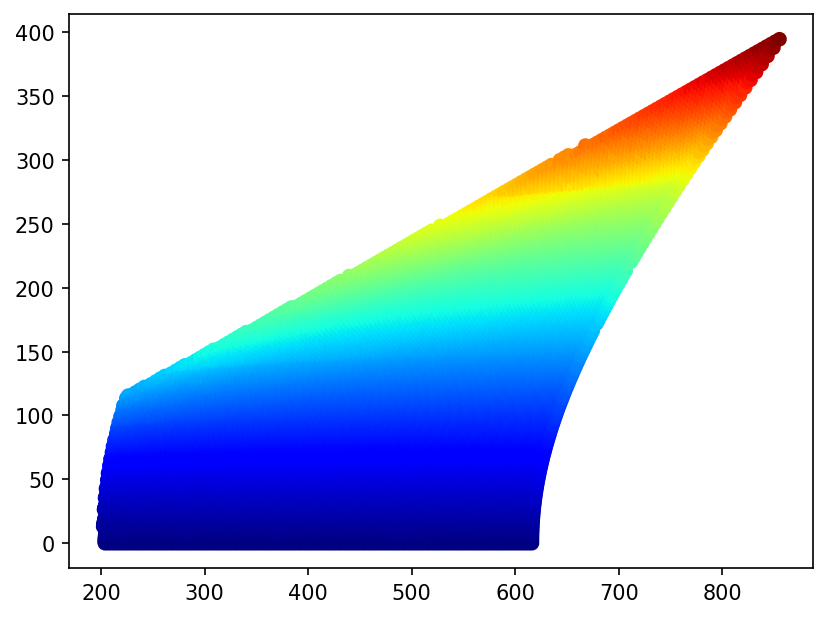

In [11]:
plt.scatter(dfg.E_init, dfg.L_init, c=np.imag(dfg.integral_relative),cmap="jet")

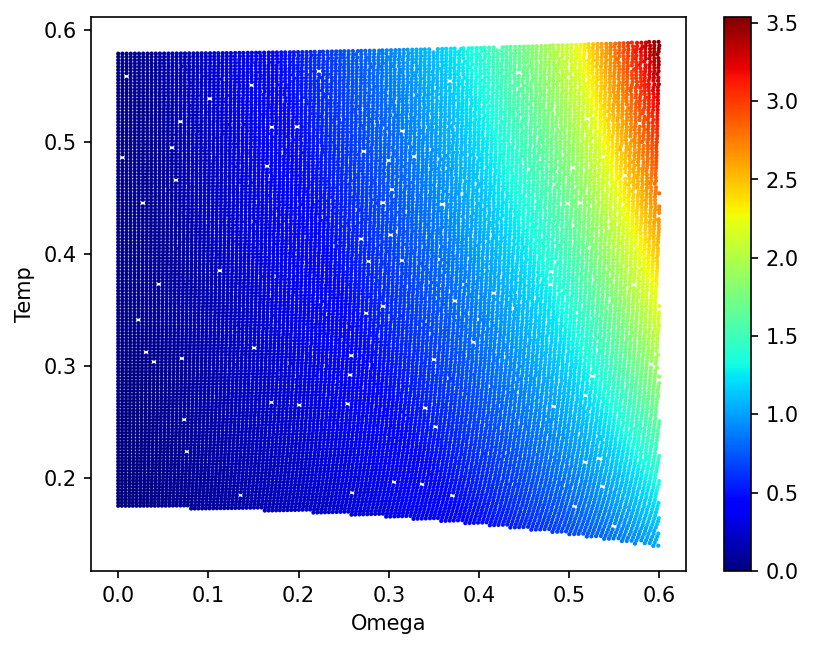

In [13]:
plt.scatter(dfg.Omega, dfg.Temp, c=np.imag(dfg.integral_relative),cmap="jet", s=1)
plt.xlabel("Omega")
plt.ylabel("Temp")
# plt.scatter(dfg.Omega, dfg.Temp, c=dfg["std"]/np.imag(dfg["integral_relative"]))
plt.colorbar()

/home/ashmat/miniconda3-vesta/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


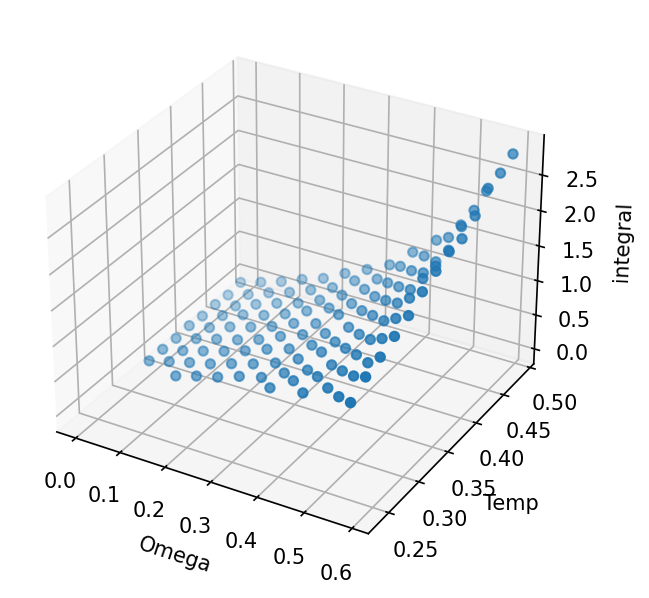

In [49]:
fig = plt.gcf()
ax = fig.add_subplot(projection='3d')

ax.scatter(dfg.Omega, dfg.Temp, np.imag(dfg.integral_relative))

ax.set_xlabel('Omega')
ax.set_ylabel('Temp')
ax.set_zlabel('integral')
plt.show()

In [17]:
data.shape

(1, 1, 1000)

In [19]:
items[0].history["ac_vc"].shape

(1, 1000)

In [20]:
data.shape

(1, 1, 1000)

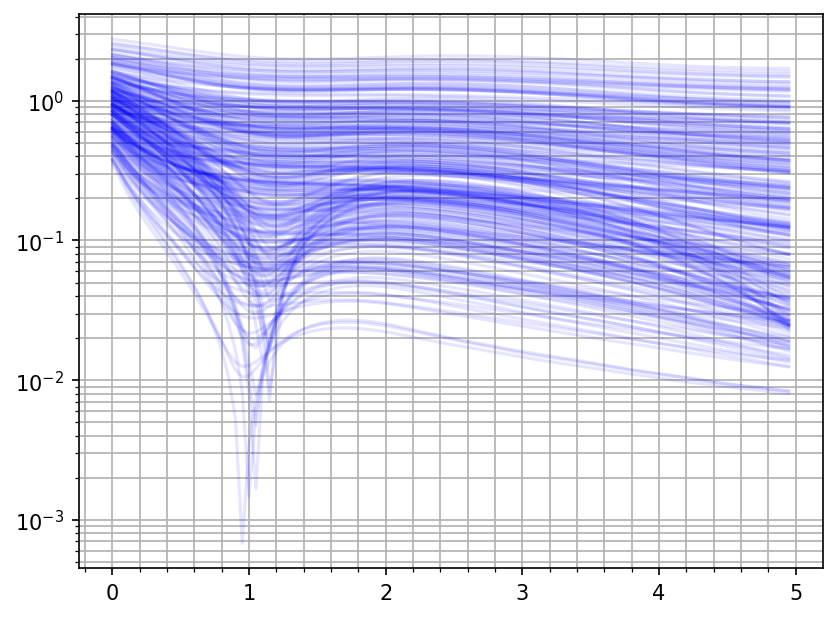

In [69]:
_k = 0
for gp_name, ids in list(gb.groups.items())[::100]:
    data = np.stack([items[i].history["ac_vc"].mean(axis=0) for i in ids])

    O = np.mean([items[i].history["Omega"] for i in ids])
    T = np.mean([items[i].history["Temp"] for i in ids])

    data = (data)[:,:100]

    mean = np.mean(data, axis=0)
#     if not ((0.069 > np.abs(mean[0]) > 0.068)):
# #         continue
#         pass
#     print(gp_name)
    ts = np.arange(len(mean))*dt

    plt.plot(ts, np.abs(mean), color="blue", alpha=0.1)
    _k+=1
#     if _k>=200:
#         break


plt.yscale("log")
plt.minorticks_on()
plt.grid(which="both")

In [42]:
def plot_mean_std(x, mean, std, color=0, label=""):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if isinstance(color, int):
        color = colors[color % len(colors)]

    plt.plot(x, mean,color=color, label=label)
    plt.fill_between(x, (mean + std), (mean - std), color=color, alpha=0.1)

In [50]:
def get_gamma(gp_name, W):
    ids = gb.groups[gp_name]
    
    data = np.stack([items[i].history["ac_vc_relative"].mean(axis=0) for i in ids])

    O = np.mean([items[i].history["Omega"] for i in ids])
    T = np.mean([items[i].history["Temp"] for i in ids])

    data = (data)[:,:W]

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)/np.sqrt(len(data))
    ts = np.arange(len(mean))*dt
    
    def f(gamma, W):
        if gamma < 0.0001:
            return np.inf

    #     W = 200
        c = Cr(ts[:W], gamma, T, O)
        c1 = mean[:W]
        d = c-c1
        return np.real(d.dot(d.conj())) / len(d)
    
    optres = scipy.optimize.minimize(f, 1, args=(W,))
    return {"crit": optres.fun, "gamma": optres.x[0]}
    
    

In [52]:
dfg = dfg.join(pd.DataFrame([get_gamma(gp_name, 200) for gp_name in tqdm(dfg.index)], index=dfg.index))

100%|██████████| 18954/18954 [01:03<00:00, 296.17it/s]


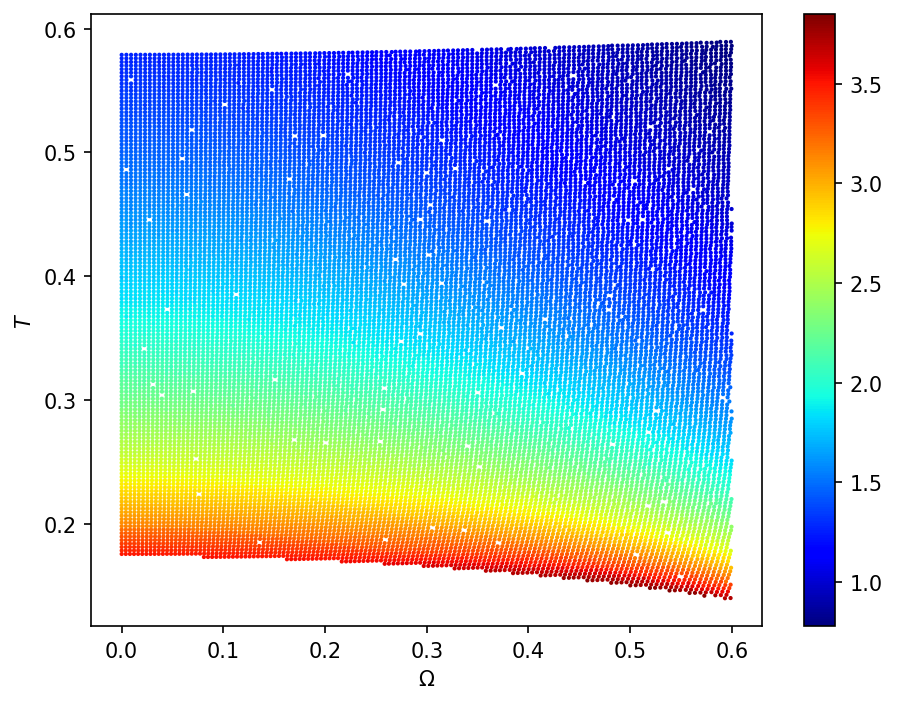

In [54]:
plt.scatter(np.real(dfg.Omega), np.real(dfg.Temp), c=dfg.gamma,cmap="jet", s=1)
plt.xlabel(r"$\Omega$")
plt.ylabel(r"$T$")
# plt.scatter(dfg.Omega, dfg.Temp, c=dfg["std"]/np.imag(dfg["integral_relative"]))
plt.colorbar()
plt.tight_layout()
plt.savefig("omega-temp-grid.pdf")

In [55]:
dfg.index

MultiIndex([(201.893,  12.964),
            (202.022,  13.625),
            (202.156,  14.288),
            (202.297,  14.953),
            (202.445,   15.62),
            (  202.6,   16.29),
            (202.725,  26.275),
            (202.761,  16.961),
            (202.929,  17.635),
            ( 202.99,  26.984),
            ...
            ( 839.11, 387.052),
            (839.824, 379.624),
            (841.465, 384.239),
            (843.199, 388.935),
            (843.858, 381.445),
            (845.526,  386.09),
            (847.289, 390.819),
            (849.587, 387.942),
            (851.378, 392.703),
            (855.467, 394.586)],
           names=['E_init', 'L_init'], length=18954)

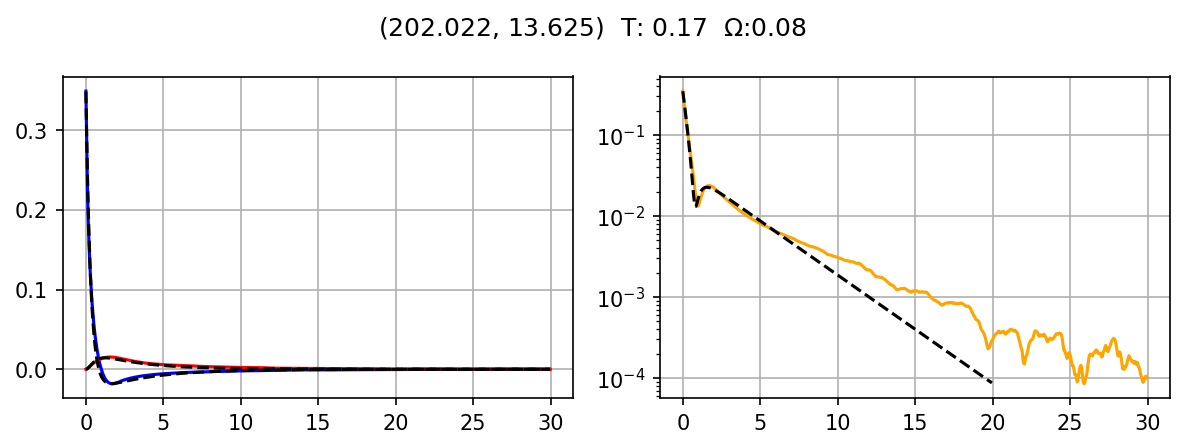

In [61]:
group_name = (706.275, 321.562)
group_name = (839.824, 379.624)
group_name = (202.022,  13.625)
# group_name = (342.329,  22.976)

ids = gb.groups[group_name]
i=0

data = np.stack([items[i].history["ac_vc_relative"].mean(axis=0) for i in ids])

O = np.mean([items[i].history["Omega"] for i in ids])
T = np.mean([items[i].history["Temp"] for i in ids])
gamma = dfg.loc[group_name].gamma

data = (data)[:,:600]

mean = np.mean(data, axis=0)
ts = np.arange(len(mean))*dt

plt.figure(figsize=(8,3))
plt.suptitle(str(group_name) + f"  T: {T:0.2f}" + r"  $\Omega$" + f":{O:0.2f}")

plt.subplot(121)
plt.plot(ts, np.real(mean), color="blue")
plt.plot(ts, np.imag(mean), color="red")

plt.plot(ts, np.real(Cr(ts, gamma=gamma, T =T, O=O )), color="black", ls="--")
plt.plot(ts, np.imag(Cr(ts, gamma=gamma, T =T, O=O )), color="black", ls="--")
plt.grid()

plt.subplot(122)
# plt.title(str(group_name) + f"  T: {T:0.2f}" + r"  $\Omega$" + f":{O:0.2f}")
plt.plot(ts[:600], np.abs(mean)[:600], color="orange")
plt.yscale("log")
plt.plot(ts[:400], np.abs(Cr(ts[:400], gamma=gamma, T =T, O=O )), color="black", ls="--")
plt.grid()

plt.tight_layout()
plt.savefig("fit-test-"+str(group_name)+".pdf")

In [60]:
ts[200]

10.0

In [213]:
def f(gamma, W):
    if gamma < 0.0001:
        return np.inf
    
#     W = 200
    c = Cr(ts[:W], gamma, T, O)
    c1 = mean[:W]
    d = c-c1
    return np.real(d.dot(d.conj())) / len(d)

In [222]:
scipy.optimize.minimize(f, 1, args=(350,))

      fun: 0.00615154279926422
 hess_inv: array([[0.43707736]])
      jac: array([4.24915925e-08])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([0.5919625])

In [214]:
tmp = [(W, scipy.optimize.minimize(f, 1, args=(W,))) for W in np.linspace(1,1000,100).astype(int)]

/home/ashmat/miniconda3-vesta/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/ashmat/miniconda3-vesta/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/ashmat/miniconda3-vesta/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [215]:
tmp[0][1].fun

0.0034307300198429874

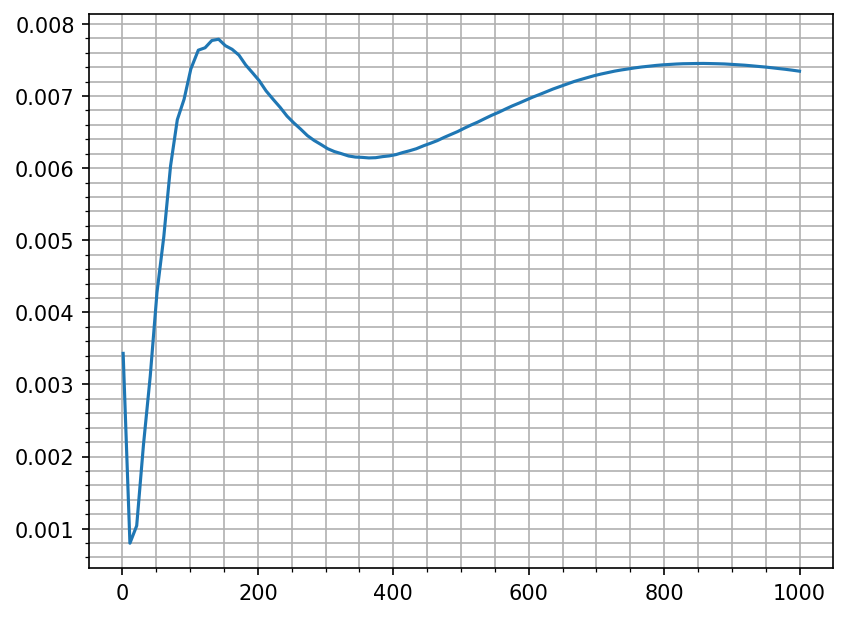

In [221]:
plt.plot([t[0] for t in tmp], [t[1].fun for t in tmp])
plt.minorticks_on()
plt.grid(which="both")

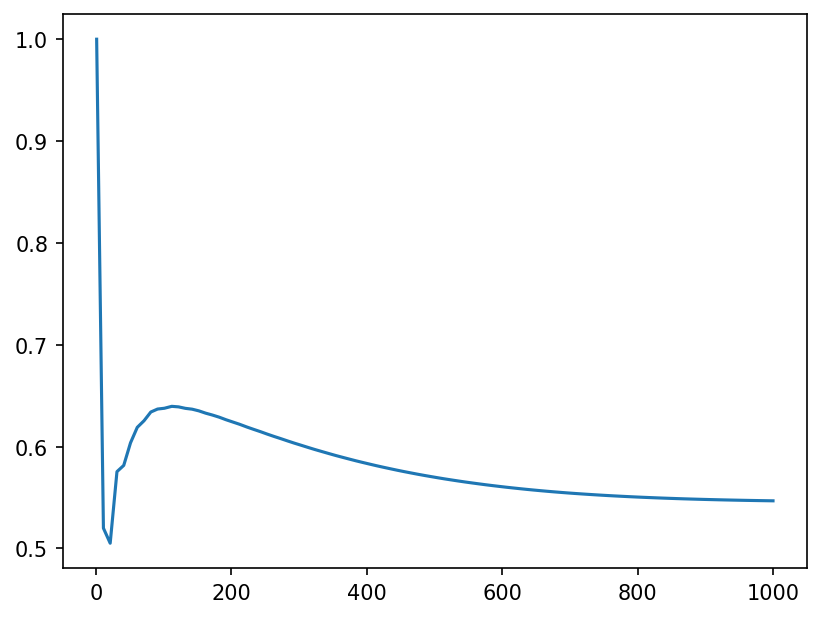

In [217]:
plt.plot([t[0] for t in tmp], [t[1].x[0] for t in tmp])

In [218]:
tmp[-1][1]

      fun: 0.00734517494656041
 hess_inv: array([[0.84804236]])
      jac: array([-7.53207132e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([0.54669742])

In [205]:
optres.x[0]

0.5807351995335652

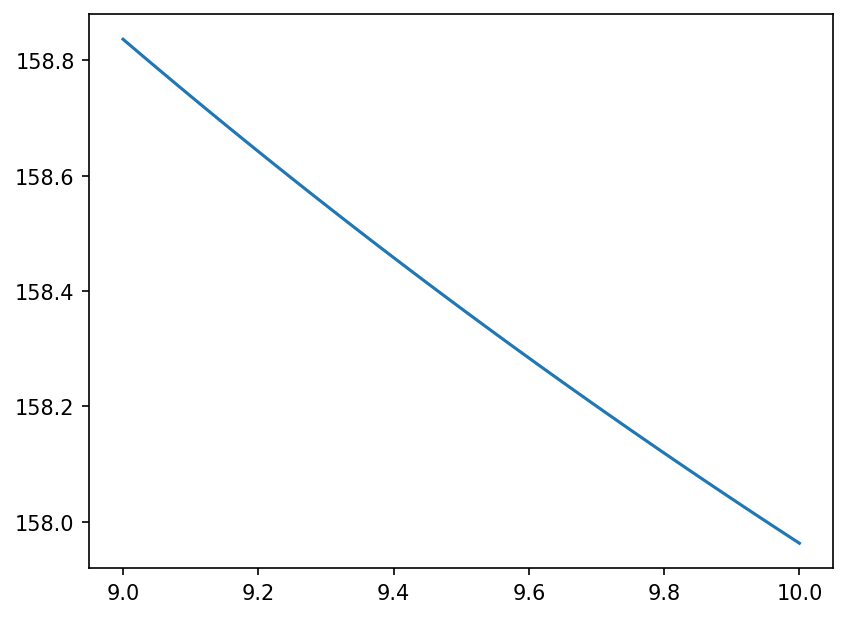

In [188]:
gs = np.linspace(9, 10)
plt.plot(gs,[f(g,40) for g in gs])

In [159]:
import scipy.optimize

In [156]:
O, T

(0.09521367, 0.43537325)

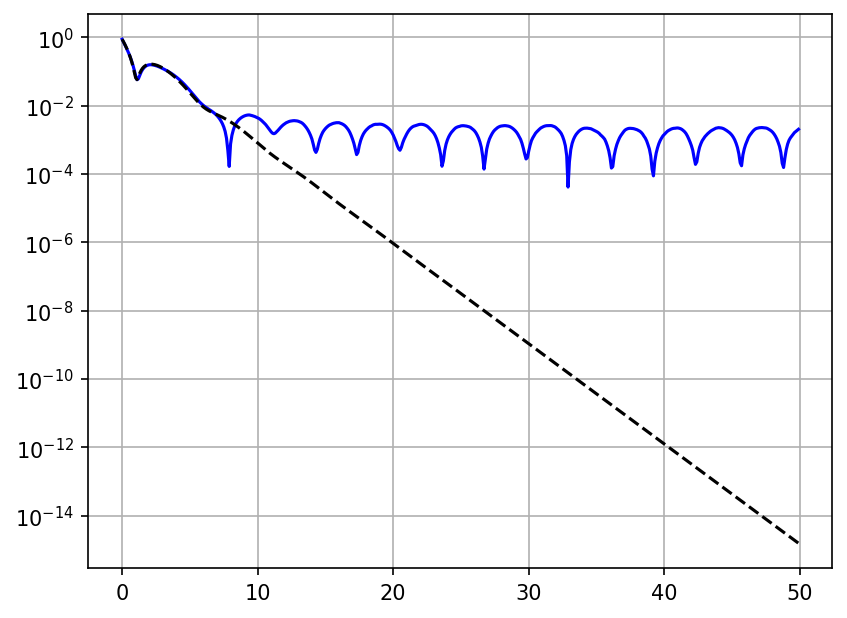

In [155]:
ids = gb.groups[(473.184, 31.729)]
i=0

data = np.stack([items[i].history["ac_relative"] for i in ids])

O = np.mean([items[i].history["Omega"] for i in ids])
T = np.mean([items[i].history["Temp"] for i in ids])

data = (data)[:,:500]

mean = np.mean(data, axis=0)
# std = np.std(data, axis=0)/np.sqrt(len(data))
ts = np.arange(len(mean))*dt

plt.plot(ts, np.abs(mean), color="blue")
gamma = 1.6

plt.plot(ts, np.abs(Cr(ts, gamma=gamma, T =T, O=O )), color="black", ls="--")

plt.yscale("log")
plt.plot()
plt.grid()


In [125]:
mean[40]

(1.2154131764557667+1.1284592333285595j)

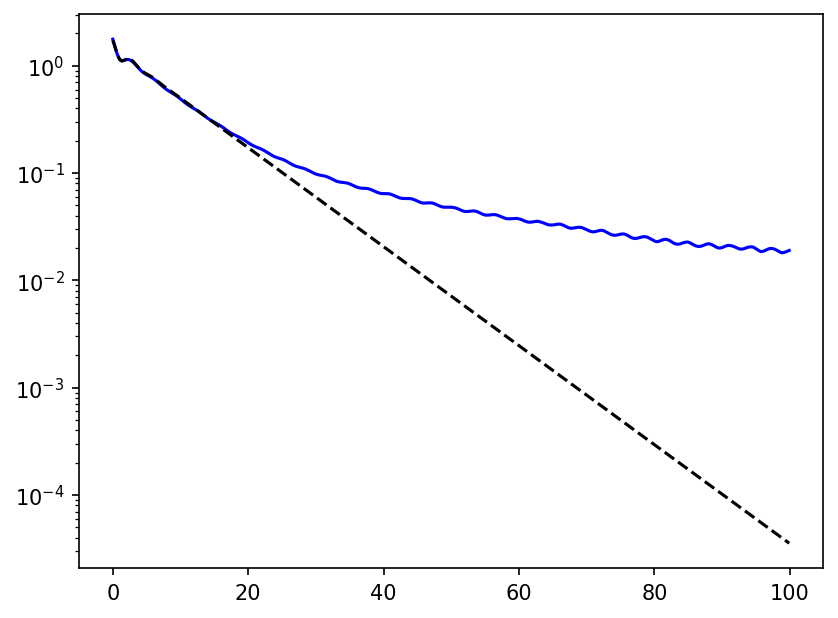

In [103]:
plt.plot(ts, np.abs(mean), color="blue")

plt.plot(ts, np.abs(Cr(ts, gamma=gamma, T =T, O=O )), color="black", ls="--")
plt.yscale("log")

In [ ]:
for line in df

## Distribution test

In [93]:
item = items[1540]

In [94]:
item.load_history()

In [96]:
vs = item.history["vs"]

In [97]:
vs.shape

(40001, 3, 343)

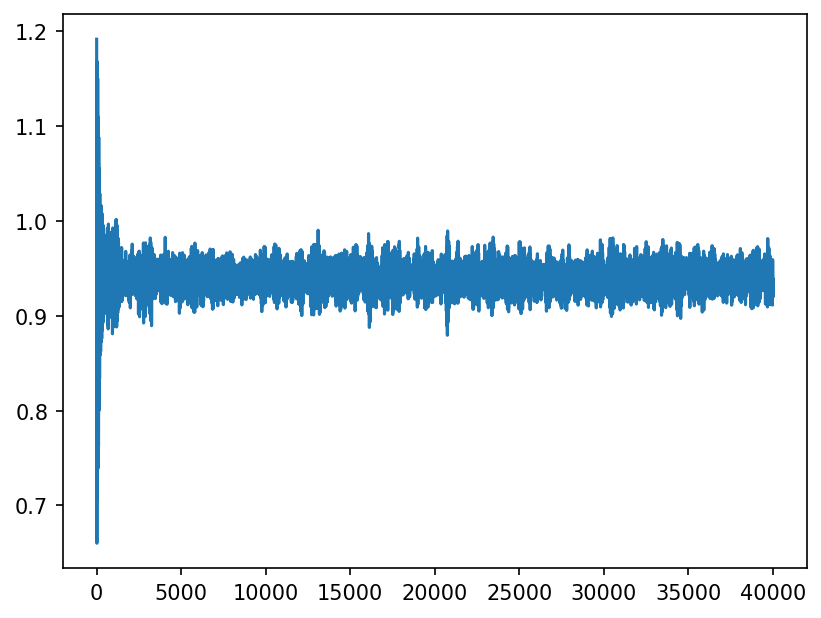

In [102]:
plt.plot(vs[:,:2].std(axis=(1,2)))

In [105]:
from scipy.stats import norm,normaltest, probplot

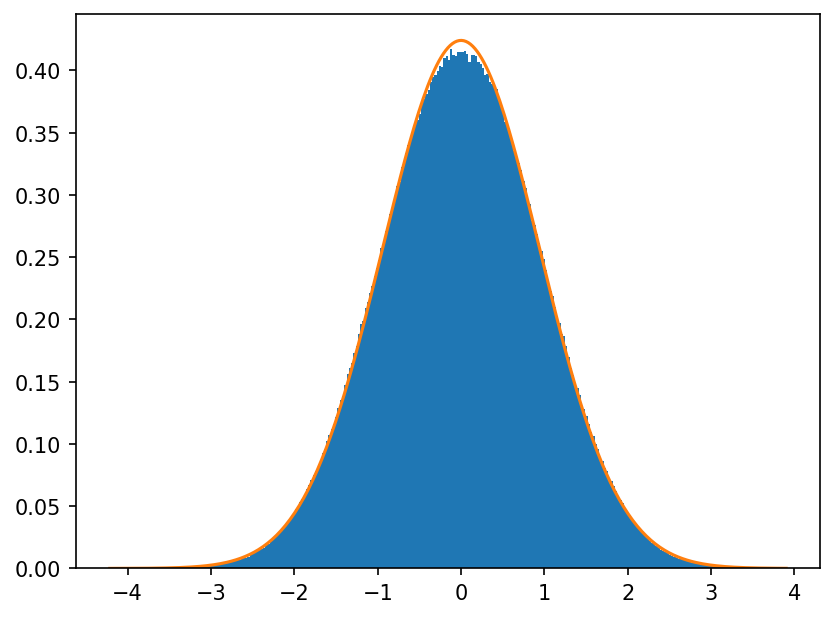

In [111]:
points = vs[:5000,:2].flatten()

_,xs,_ = plt.hist(points, bins=300, density=1)
plt.plot(xs, norm.pdf(xs, loc=np.mean(points), scale=np.std(points)))


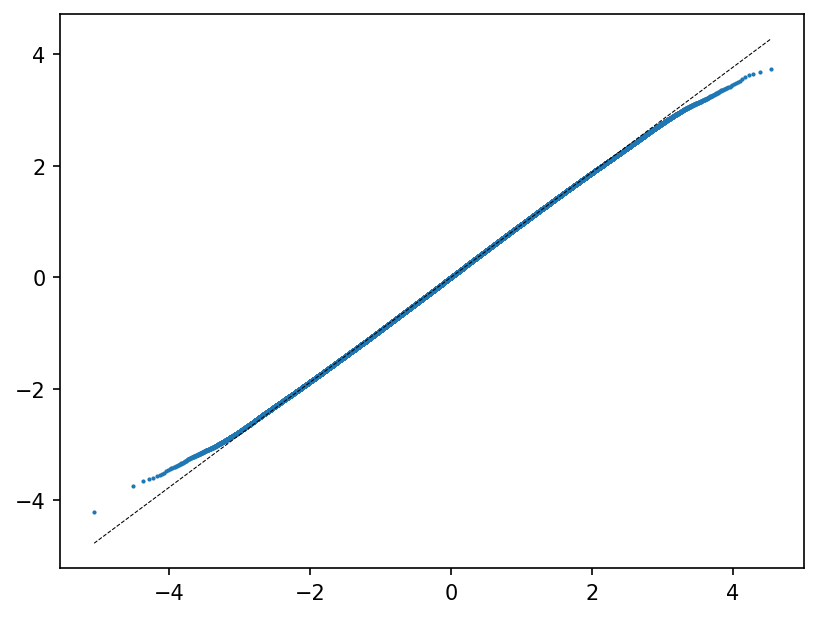

In [112]:
((osm, osr), (slope, intercept, _r)) = probplot(points, dist="norm",)
sp=10
plt.scatter(osm[::sp], osr[::sp], s=1)
plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)

In [124]:
omegas = np.linspace(0,0.95,200)
temps = np.linspace(0.1, 0.5, 200)

P0=202.60790384216835; I0=292.4312; N=343
i=0
data = defaultdict(list)
for o in omegas:
    for t in temps:
        e=t * (3 - o**2) / (1 - o**2)
        l=343 * t * 2 * o / (1-o**2)
        c1=0;c2=0
        if e<1:
            c1=1
        E1 = N * e - P0
        if E1 < 0:
            continue
        if l>=np.sqrt(2*I0*E1):
            c2=2
        data["c"].append(c1+c2)
        
        data["L_init"].append(l)
        data["E_init"].append(343*e)
        data["Omega"].append(o)
        data["Temp"].append(t)
df = pd.DataFrame(data)

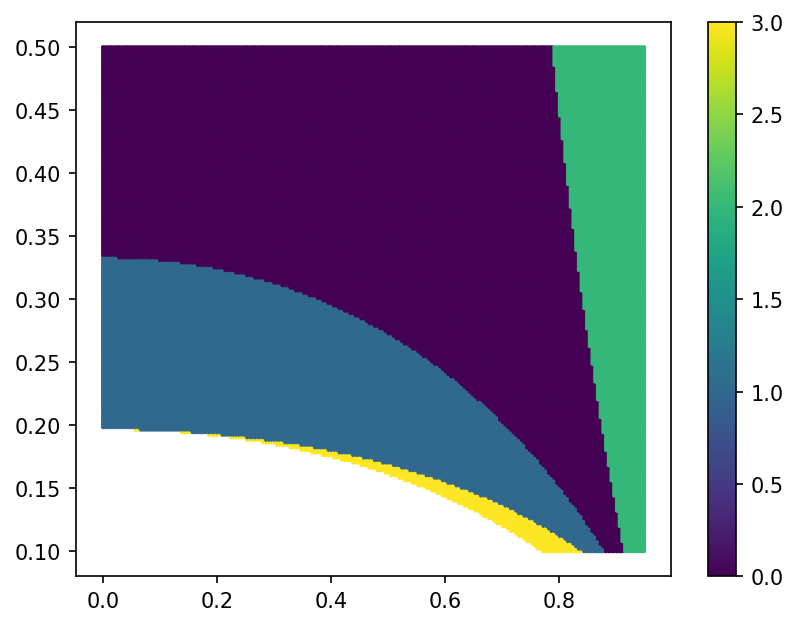

In [125]:
plt.scatter(df.Omega, df.Temp, c=df["c"],s=1)
plt.colorbar()
# plt.xlim([300,700])
# plt.ylim(0,600)